In [1]:
!pip install pycaret pandas shap

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for imbalanced-learn>=0.12.0 from https://files.pythonhosted.org/packages/9d/41/721fec82606242a2072ee909086ff918dfad7d0199a9dfd4928df9c72494/imbalanced_learn-0.13.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhosted.org/packages/63/a8/e2929e8654c15a64504022a8bd1444e748a8bda3450a4868567caf19a6c1/category_encoders-2.8.0-py3-none-any.whl.metadata
  Using cached category_encoders-2.8.0-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for nbformat>=4.2.0 from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4b


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import datetime

# --- 1️⃣ โหลดข้อมูล ---
df = pd.read_csv("D:\Term_Project\pm_2.5\pm2_5_last.csv")

# 🛠 ตรวจสอบว่ามีคอลัมน์ year, month, day หรือไม่
print("📌 คอลัมน์ที่มีใน DataFrame:", df.columns)

# ✅ แปลงเป็น datetime ถ้ามี year, month, day
if {'year', 'month', 'day'}.issubset(df.columns):
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
    df = df.dropna(subset=['date'])  # ลบค่าที่แปลงไม่ได้
else:
    raise KeyError("❌ คอลัมน์ 'year', 'month', 'day' หายไปจาก DataFrame")

# ✅ รีเซ็ต index เพื่อป้องกันค่าซ้ำ
df = df.reset_index(drop=True)

# ✅ ตรวจสอบว่ามี 'date' จริงไหม
if 'date' not in df.columns:
    raise KeyError("❌ คอลัมน์ 'date' ไม่ได้ถูกสร้างขึ้น")

# --- 2️⃣ สร้างฟีเจอร์ใหม่ ---
def categorize_hour(hour):
    if 5 <= hour < 11:
        return "Morning"
    elif 11 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df["hour_group"] = df["hour"].apply(categorize_hour)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofyear'] = df['date'].dt.dayofyear
df['weekday'] = df['date'].dt.weekday.astype(str)

# --- 3️⃣ ตั้งค่า PyCaret และเทรนโมเดล ---
exp = setup(df, target='pm_2_5', session_id=123, train_size=0.8,
            categorical_features=['hour_group', 'weekday'], index=False, verbose=False)

# ใช้ Extra Trees Regressor
model = create_model('et')
final_model = finalize_model(model)

# --- 4️⃣ ฟังก์ชันทำนาย 7 วันข้างหน้า ---
def predict_next_7_days(model, df):
    last_date = df['date'].max()
    future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]

    future_df = pd.DataFrame({
        'humidity': [df['humidity'].mean()] * 7,
        'temperature': [df['temperature'].mean()] * 7,
        'hour': [12] * 7,
        'hour_sin': [np.sin(2 * np.pi * 12 / 24)] * 7,
        'hour_cos': [np.cos(2 * np.pi * 12 / 24)] * 7,
        'day': [d.day for d in future_dates],
        'month': [d.month for d in future_dates],
        'dayofyear': [d.timetuple().tm_yday for d in future_dates],
        'weekday': [str(d.weekday()) for d in future_dates],
        'hour_group': ['Afternoon'] * 7
    })



RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=4, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

In [4]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\cleaned_data (2)-7days.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    # คำนวณ IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตของ outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # แทนที่ outlier ด้วยค่ามัธยฐาน
    median_value = series.median()
    series = series.where((series >= lower_bound) & (series <= upper_bound), median_value)

    # เติมค่าที่หายไปด้วยค่ามัธยฐาน
    series = series.fillna(median_value)

    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Random Forest Regressor
model = create_model("rf")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# ใช้ค่าเฉลี่ยล่าสุดของความชื้นและอุณหภูมิ
latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 27572, number of used features: 9
[LightGBM] [Info] Start training from score 12.941168


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(34465, 8)"
4,Transformed data shape,"(34465, 2)"
5,Transformed train set shape,"(27572, 2)"
6,Transformed test set shape,"(6893, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9695,21.2358,4.6082,0.7004,0.3266,0.3148
1,3.0269,22.4206,4.7350,0.7086,0.3233,0.3150
2,2.9007,20.5783,4.5363,0.7153,0.3210,0.3094
3,2.9944,22.0048,4.6909,0.6825,0.3241,0.3531
4,2.9344,20.5894,4.5376,0.7222,0.3212,0.3153
5,2.9970,20.5434,4.5325,0.7153,0.3155,0.3021
6,3.0700,21.5823,4.6457,0.7018,0.3267,0.3220
7,2.9635,21.2745,4.6124,0.6969,0.3328,0.3256
8,2.9405,20.5146,4.5293,0.7206,0.3207,0.3662


               datetime  prediction_label
0   2025-01-28 00:00:00         17.528438
1   2025-01-28 01:00:00         17.717172
2   2025-01-28 02:00:00         18.687602
3   2025-01-28 03:00:00         18.808969
4   2025-01-28 04:00:00         18.512258
..                  ...               ...
163 2025-02-03 19:00:00         16.687453
164 2025-02-03 20:00:00         17.879172
165 2025-02-03 21:00:00         20.349476
166 2025-02-03 22:00:00         14.937534
167 2025-02-03 23:00:00         15.160081

[168 rows x 2 columns]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 27572, number of used features: 9
[LightGBM] [Info] Start training from score 12.941168


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(34465, 8)"
4,Transformed data shape,"(34465, 2)"
5,Transformed train set shape,"(27572, 2)"
6,Transformed test set shape,"(6893, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9695,21.2358,4.6082,0.7004,0.3266,0.3148
1,3.0269,22.4206,4.7350,0.7086,0.3233,0.3150
2,2.9007,20.5783,4.5363,0.7153,0.3210,0.3094
3,2.9944,22.0048,4.6909,0.6825,0.3241,0.3531
4,2.9344,20.5894,4.5376,0.7222,0.3212,0.3153
5,2.9970,20.5434,4.5325,0.7153,0.3155,0.3021
6,3.0700,21.5823,4.6457,0.7018,0.3267,0.3220
7,2.9635,21.2745,4.6124,0.6969,0.3328,0.3256
8,2.9405,20.5146,4.5293,0.7206,0.3207,0.3662


               datetime  prediction_label
0   2025-01-28 00:00:00         17.528438
1   2025-01-28 01:00:00         17.717172
2   2025-01-28 02:00:00         18.687602
3   2025-01-28 03:00:00         18.808969
4   2025-01-28 04:00:00         18.512258
..                  ...               ...
163 2025-02-03 19:00:00         16.687453
164 2025-02-03 20:00:00         17.879172
165 2025-02-03 21:00:00         20.349476
166 2025-02-03 22:00:00         14.937534
167 2025-02-03 23:00:00         15.160081

[168 rows x 2 columns]


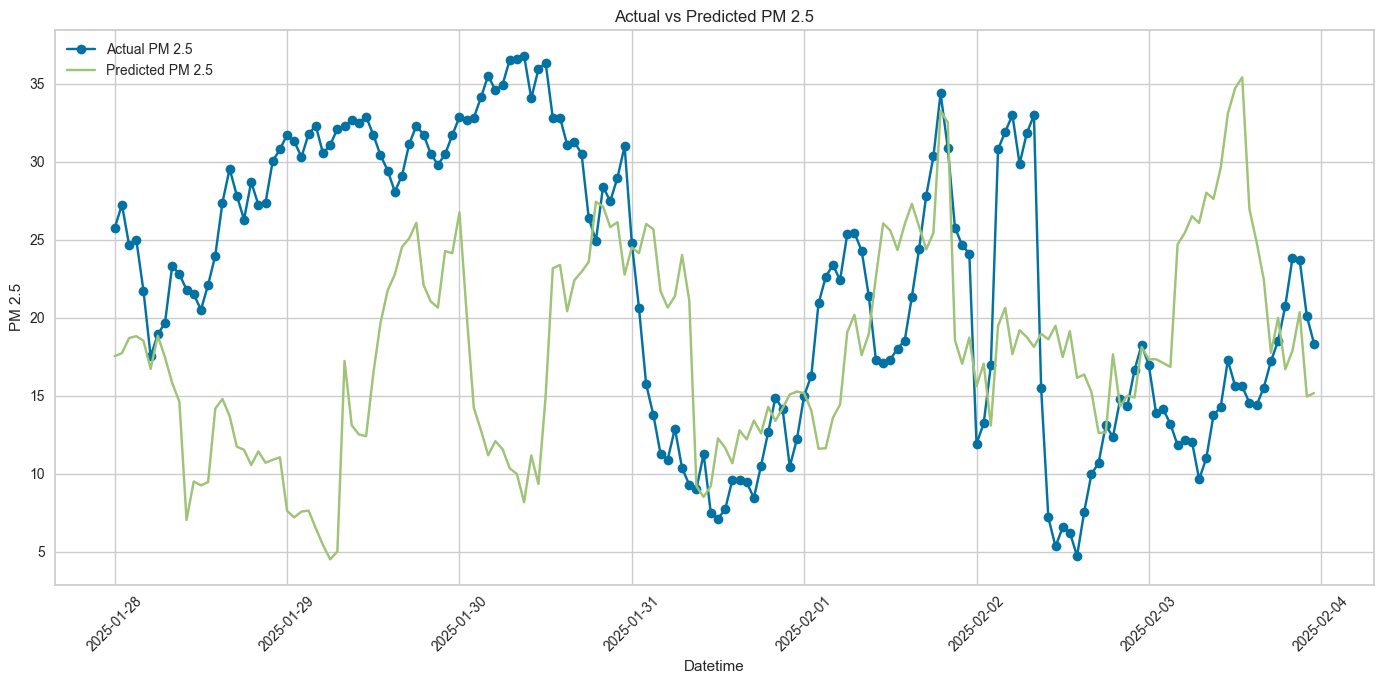

In [6]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt  # เพิ่มไลบรารีสำหรับพล็อตกราฟ

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\cleaned_data (2)-7days.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    # คำนวณ IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตของ outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # แทนที่ outlier ด้วยค่ามัธยฐาน
    median_value = series.median()
    series = series.where((series >= lower_bound) & (series <= upper_bound), median_value)

    # เติมค่าที่หายไปด้วยค่ามัธยฐาน
    series = series.fillna(median_value)

    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Random Forest Regressor
model = create_model("rf")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# ใช้ค่าเฉลี่ยล่าสุดของความชื้นและอุณหภูมิ
latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())

# ---- เพิ่มส่วนของการพล็อตกราฟเปรียบเทียบ ----
# สร้างคอลัมน์ 'predicted_pm_2_5' ใน predictions DataFrame
predictions['predicted_pm_2_5'] = predictions[prediction_column]

# สร้างคอลัมน์ 'actual_pm_2_5' ใน predictions DataFrame โดยใช้ค่าจริงจาก df_cleaned
# เนื่องจากเราทำนายล่วงหน้า 7 วัน (168 ชั่วโมง) เราจะใช้ค่าจริงจาก df_cleaned ที่ตรงกับช่วงเวลานี้
predictions['actual_pm_2_5'] = df_cleaned['pm_2_5'].iloc[-168:].reset_index(drop=True)

# พล็อตกราฟเปรียบเทียบ
plt.figure(figsize=(14, 7))
plt.plot(predictions['datetime'], predictions['actual_pm_2_5'], label='Actual PM 2.5', marker='o')
plt.plot(predictions['datetime'], predictions['predicted_pm_2_5'], label='Predicted PM 2.5', marker='x')
plt.xlabel('Datetime')
plt.ylabel('PM 2.5')
plt.title('Actual vs Predicted PM 2.5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\cleaned_data (2)-7days.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = series.median()
    series = series.where((series >= lower_bound) & (series <= upper_bound), median_value)
    series = series.fillna(median_value)
    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Extra Trees Regressor
model = create_model("et")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 27572, number of used features: 9
[LightGBM] [Info] Start training from score 12.941168


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(34465, 8)"
4,Transformed data shape,"(34465, 2)"
5,Transformed train set shape,"(27572, 2)"
6,Transformed test set shape,"(6893, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0830,23.1413,4.8105,0.6735,0.3411,0.3266
1,3.1334,24.7057,4.9705,0.6789,0.3398,0.3249
2,3.0178,22.5155,4.7451,0.6885,0.3327,0.3159
3,3.1188,23.9389,4.8927,0.6546,0.3360,0.3736
4,3.0401,22.2552,4.7175,0.6997,0.3343,0.3209
5,3.1081,22.3312,4.7256,0.6905,0.3302,0.3151
6,3.1893,23.5600,4.8539,0.6744,0.3405,0.3332
7,3.0579,22.5793,4.7518,0.6783,0.3430,0.3375
8,3.0564,22.4708,4.7403,0.6940,0.3323,0.3656


               datetime  prediction_label
0   2025-01-28 00:00:00         17.409315
1   2025-01-28 01:00:00         15.058259
2   2025-01-28 02:00:00         14.505208
3   2025-01-28 03:00:00         20.632487
4   2025-01-28 04:00:00         24.464285
..                  ...               ...
163 2025-02-03 19:00:00          9.778274
164 2025-02-03 20:00:00          9.070138
165 2025-02-03 21:00:00          9.140615
166 2025-02-03 22:00:00          7.088001
167 2025-02-03 23:00:00          8.207350

[168 rows x 2 columns]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X = df_cleaned.drop(columns=["pm_2_5", "datetime"])  # ฟีเจอร์
y = df_cleaned["pm_2_5"]  # เป้าหมาย (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# ทำนายค่าบนชุดฝึกและชุดทดสอบ
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ประเมินประสิทธิภาพด้วย MSE, R², และ MAPE
test_mse = mean_squared_error(y_test, y_test_pred)

test_r2 = r2_score(y_test, y_test_pred)

test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# แสดงผลลัพธ์
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")
print(f"Test MAPE: {test_mape}")


Test MSE: 15.664501143844321
Test R²: 0.7801560915640265
Test MAPE: 0.2853729382207431
